In [3]:
pip install pyswarms deap

Note: you may need to restart the kernel to use updated packages.


2023-10-10 19:58:20,859 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████████|20/20, best_cost=0
2023-10-10 19:58:25,238 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.71113753 0.59307807 0.6071517  0.07206974 0.06534271 0.33583046
 0.99968663 0.97194792 0.11976132 0.53791203 0.82201859 0.63085405
 0.34761529 0.63368069 0.71870167 0.77953976]


Number of selected features:  11
Accuracy:  0.8307692307692308
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        39
           1       0.89      0.65      0.76        26

    accuracy                           0.83        65
   macro avg       0.85      0.80      0.81        65
weighted avg       0.84      0.83      0.82        65



C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: ['Unnamed: 21']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: ['Unnamed: 21']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


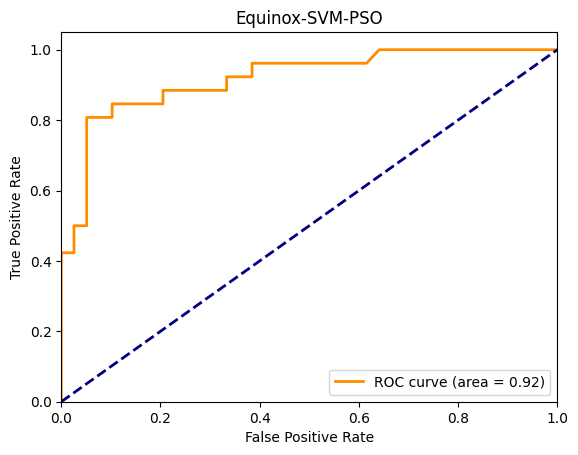

In [4]:
import pandas as pd
import numpy as np
import pyswarms as ps
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Load the data
data = pd.read_csv('equinox.csv')
data['bugs_binary'] = data['bugs'].apply(lambda x: 1 if x > 0 else 0)
columns_to_drop = ['classname', 'bugs', 'nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs', 'bugs_binary']
X = data.drop(columns=columns_to_drop)
y = data['bugs_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the evaluation function for PSO
def evalFeatureSelection(x):
    n_particles = x.shape[0]
    fitness = []

    for i in range(n_particles):
        individual = [1 if val > 0.5 else 0 for val in x[i]]
        selected_features = [i for i, val in enumerate(individual) if val == 1]

        if len(selected_features) == 0:
            fitness.append(0)
            continue

        X_train_selected = X_train.iloc[:, selected_features]
        X_test_selected = X_test.iloc[:, selected_features]
        
        # Here, make a copy of y_train for this iteration
        y_train_copy = y_train[X_train_selected.index]

        drop_indices = X_train_selected[X_train_selected.isna().any(axis=1)].index
        X_train_selected = X_train_selected.drop(drop_indices)
        y_train_copy = y_train_copy.drop(drop_indices)

        # Do the same for testing data if needed:
        drop_indices_test = X_test_selected[X_test_selected.isna().any(axis=1)].index
        X_test_selected = X_test_selected.drop(drop_indices_test)

        # Condition to check if lengths are non-zero
        if len(X_train_selected) > 0 and len(y_train_copy) > 0:
            ## !classifier here!
            clf = SVC(probability=True)
            clf.fit(X_train_selected, y_train_copy)
            y_pred = clf.predict(X_test_selected)
            accuracy = accuracy_score(y_test, y_pred)
            fitness.append(accuracy)
        else:
            fitness.append(0)  # or any default fitness value you prefer

    return np.array(fitness)


# Configure the PSO algorithm
n_features = X_train.shape[1]
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
bounds = (np.zeros(n_features), np.ones(n_features))
optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=n_features, options=options, bounds=bounds)

# Run the PSO algorithm for feature selection
cost, pos = optimizer.optimize(evalFeatureSelection, iters=20, verbose=True)
best_individual = [1 if val > 0.5 else 0 for val in pos]
selected_features = [i for i, val in enumerate(best_individual) if val == 1]
print("Number of selected features: ", len(selected_features))

# Train and evaluate the KNN classifier using the best feature subset found
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

imputer = SimpleImputer(strategy="mean")
X_train_selected = imputer.fit_transform(X_train_selected)
X_test_selected = imputer.transform(X_test_selected)

## !classifier here!
clf = SVC(probability=True)

clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]

print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
df = pd.DataFrame({
    'FPR': fpr,
    'TPR': tpr,
    'AUC': roc_auc
})
df.to_csv('./AUC_Extracts/Equinox/Equinox_SVM_PSO.csv', index=False)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Equinox-SVM-PSO')
plt.legend(loc="lower right")
plt.show()
